In [1]:
# A implementation of "A Neural probabilistic language Model, Bengio 2003
# Original paper has word level, we stick to character level 
#  

In [42]:
import torch
import torch.nn.functional as F

In [2]:
words = open('data/names.txt', 'r').read().splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [9]:
# stoi and itos 
chars = set(''.join(words))
stoi = {c:i+1 for i,c in enumerate(sorted(chars))}
stoi['.'] = 0
itos = {v:k for k,v in stoi.items()}

In [12]:
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [37]:
# create the traning data 
block_size = 3 # no of charcters in context to predict the next one 
X, Y = [], []
for word in words[:5]:
    print(word)
    #running context 
    context = [0]*block_size
    for ch in word+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join([itos[i] for i in context]), "---->", itos[ix])
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [38]:
print(X.shape,X.dtype, Y.shape)

torch.Size([32, 3]) torch.int64 torch.Size([32])


In [39]:
# embedding space 27 characters in 2D space
C = torch.randn((27,2))

In [ ]:
# C[ix]
# F.one_hot(torch.tensor(ix), num_classes=27).float() @ C
# ideally you can do both the approach 
# 1. C as a look up table and index into it 
# 2. Consider C as a first layer in nn, F.one_hot(torch.tensor(ix), num_classes=27).float() @ C

In [56]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [68]:
# first layer of nn 
W1 = torch.randn(6,100) # 3*2 input dimension, 100 neurons 
b1 = torch.randn(100)
# roughly emb @ W1 + b1
# h = emb.view(32,6) @ W1 + b1
# h = emb.view(emb.shape[0],6) @ W1 + b1
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [ ]:
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape
# torch.cat(torch.unbind(emb, 1), 1).shape
# concatenation is in efficient as it creates new tensors, as it cant manipulate views --> view is efficient 


In [70]:
# layer 2 
W2 = torch.randn(100,27) #input = 100, no of neurons/output = 27
b2 = torch.randn(27)

In [71]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [72]:
counts = logits.exp()
prob = counts/counts.sum(1, keepdim=True)

In [ ]:
# get the probab of Y values 
loss = - prob[torch.arange(32), Y].log().mean()
loss

tensor(18.2299)

### Clean up 

In [102]:
# dataset
import torch
import torch.nn.functional as F

words = open('data/names.txt', 'r').read().splitlines()
# stoi and itos 
chars = set(''.join(words))
stoi = {c:i+1 for i,c in enumerate(sorted(chars))}
stoi['.'] = 0
itos = {v:k for k,v in stoi.items()}

# create the traning data 
block_size = 3 # no of charcters in context to predict the next one 
X, Y = [], []
for word in words:
    #running context 
    context = [0]*block_size
    for ch in word+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

print(f"No of words: {len(words)}")
print(f"No of training examples: {X.shape[0]}")
print(f"Shape of X,  {X.shape}")
print(f"Shape of Y,  {Y.shape}")

No of words: 32033
No of training examples: 228146
Shape of X,  torch.Size([228146, 3])
Shape of Y,  torch.Size([228146])


In [213]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100),generator=g) # 3*2 input dimension, 100 neurons 
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g) #input = 100, no of neurons/output = 27
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [214]:
# total no of parameters
print(f"total no of parameters: {sum(p.nelement() for p in parameters)}")

total no of parameters: 3481


In [215]:
for p in parameters:
    p.requires_grad = True

In [216]:
# # learning rate 
# lre = torch.linspace(-3, 0,1000)
# lrs = 10**lre

In [222]:
# forward pass 
# lri = []
# lossi = []
for i in range(10000):
    # construct mini batching 
    ix = torch.randint(0, X.shape[0], (32,)) # size of mini batch =32 
    emb = C[X[ix]] #(32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    #print(f"Loss: {loss.item()}")
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

print(f"Loss: {loss.item()}")

Loss: 2.118293046951294


In [217]:
# testing the loss using forward pass 
emb = C[X] #(32,3,2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(f"Loss: {loss.item()}")

Loss: 19.505229949951172


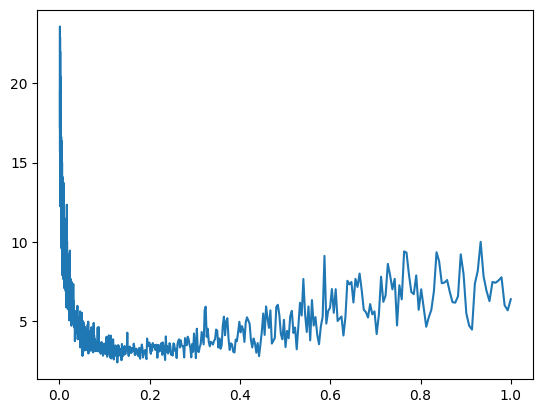

In [206]:
import matplotlib.pyplot as plt
plt.plot(lri, lossi)

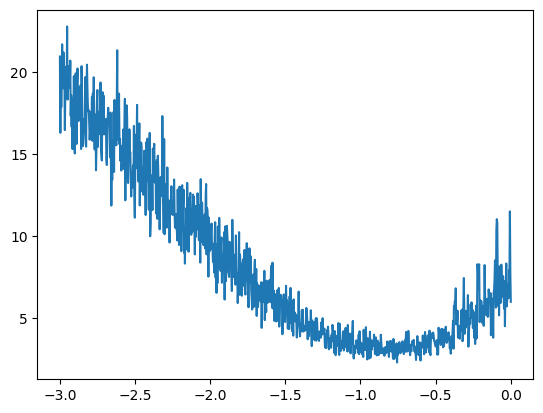

In [212]:
plt.plot(lri, lossi)

### Train, dev and test split

In [338]:
def build_dataset(words):# create the traning data 
    block_size = 4 # no of charcters in context to predict the next one 
    X, Y = [], []
    for word in words:
        #running context 
        context = [0]*block_size
        for ch in word+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

#split 
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) #10%
Xte, Yte = build_dataset(words[n2:]) #10%

torch.Size([182580, 4]) torch.Size([182580])
torch.Size([22767, 4]) torch.Size([22767])
torch.Size([22799, 4]) torch.Size([22799])


In [339]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,16), generator=g)
W1 = torch.randn((64,200),generator=g) # 4*16 input dimension, 100 neurons 
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g) #input = 100, no of neurons/output = 27
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [340]:
# total no of parameters
print(f"total no of parameters: {sum(p.nelement() for p in parameters)}")

total no of parameters: 18859


In [341]:
for p in parameters:
    p.requires_grad = True

In [342]:
stepsi = []
lossi = []

In [343]:
for i in range(200000):
    # construct mini batching 
    ix = torch.randint(0, Xtr.shape[0], (64,)) # size of mini batch =32 
    emb = C[Xtr[ix]] #(32,3,2)
    h = torch.tanh(emb.view(-1,64) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(f"Loss: {loss.item()}")
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # # track stats 
    stepsi.append(i)
    lossi.append(loss.log10().item())

print(f"Loss on the last mini batch: {loss.item()}")

Loss on the last mini batch: 1.9172178506851196


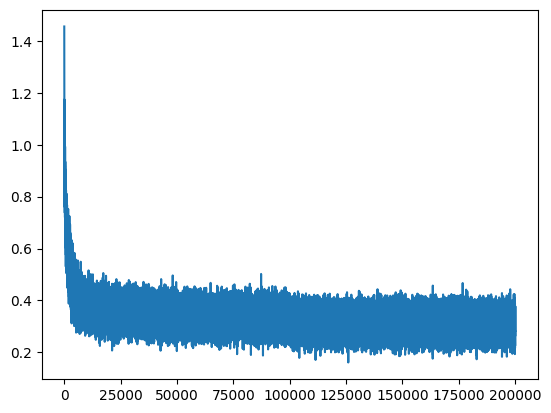

In [344]:
plt.plot(stepsi, lossi)

In [345]:
# testing the loss using forward pass on TRAINING SET
emb = C[Xtr] #(32,3,2)
h = torch.tanh(emb.view(-1,64) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(f"Loss on the training set: {loss.item()}")

Loss on the training set: 2.06654953956604


In [346]:
# testing the loss using forward pass on DEV SET
emb = C[Xdev] #(32,3,2)
h = torch.tanh(emb.view(-1,64) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(f"Loss on the dev set: {loss.item()}")

Loss on the dev set: 2.125763416290283


In [347]:
# testing the loss using forward pass on TEST SET
emb = C[Xte] #(32,3,2)
h = torch.tanh(emb.view(-1,64) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
print(f"Loss on the dev set: {loss.item()}")

Loss on the dev set: 2.129443645477295


In [357]:
# sample from the model
block_size= 4
dim = 16
for _ in range(20):
    # intialise with context
    context = [0]*4 #our context block is 4
    name = []
    while True:
        emb = C[torch.tensor([context])] # emb.sahpe ->[1, block_size, dim] although torch.tensor([context]).shape -> [1,block_size]
        h = torch.tanh(emb.view(-1,block_size*dim) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim =1)
        # get the index from sampling
        ix = torch.multinomial(probs, num_samples=1).item()
        name.append(ix)
        # update the context 
        context = context[1:] + [ix]
        if ix ==0:
            break
    print(''.join(itos[ch] for ch in name))

phid.
biclyagi.
midaylie.
mella.
sanell.
urkhiiana.
jeilana.
elmo.
ceri.
allino.
azalin.
zhaw.
massisa.
yila.
damarielyndedick.
kiyverit.
lunice.
sana.
javariah.
krysta.


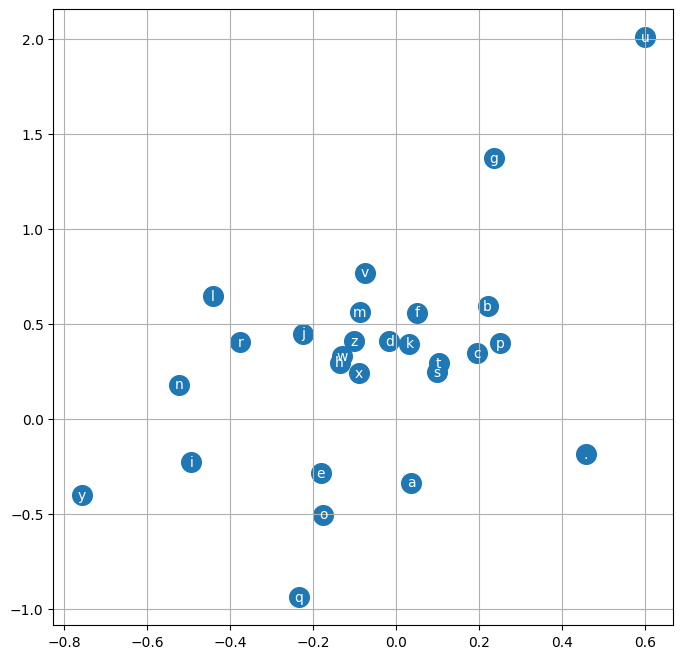

In [278]:
plt.figure(figsize =(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s= 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i], ha = "center", va = "center", color = "white")
plt.grid("minor")